# Finding Cu crystal ground state via the Augmented Plane method

This project is adapted from Thijssen.

## Theory

APW is a method for solving the single particle Schrodinger equation in a crystal. It uses the variational principle in the plane wave basis (this is viable due to Bloch's theorem). A basis element for an eigenstate labelled $\vec{k}$ is:

$$\psi_{\vec{k} + \vec{K}} = e^{i(\vec{k} + \vec{K})\cdot\vec{r}}\tag{1}$$

Due to the size of the potential near the nuclei, the basis set required is too large. APW solves this problem with the Muffin approximation. The equation near the nuclei ($r<R$) is solved exactly and related to the plane waves via boundary conditions at $R$. This allows for the variational method to be applied efficiently to the basis. For a full description of the theory see Thijssen. 

## Implementation

The variational equations are not linear, making the problem much harder to solve. In this implementation a brute force approach has been followed, the energy found for a given $\vec{k}$ is where the determinant changes sign.

This notebook attempts to apply this method to Cu. However, I can no longer access the data used in Thijssen for the potential. Because of this I have modelled the valence electrons potential (ignoring interaction between valence electrons) as:

$$V(r) = -Z_{eff}\frac{e^{-\frac{r}{r_0}}}{r}\tag{2}$$

where $Z_{eff}$ is the effective charge of the nuclei of the valence electron and $r_0$ has been found via the Thomas–Fermi approximation (this term represents the shielding of the nuclei by other electrons). 

These approximations are not particularly accurate; however, the implementation of the algorithm is correct.



In [747]:
import numpy as np
from scipy import special as sp
import matplotlib.pyplot as plt

In [748]:
#constants
a = 6.822 
vol = 3*(a**3)/4

l_max = 2*(3+2+1) + 4
nLim = 2 

#define recipricol lattice vectors 
b1 = 2*np.pi*np.array([-1,1,1])/a
b2 = 2*np.pi*np.array([1,-1,1])/a
b3 = 2*np.pi*np.array([1,1,-1])/a
Ks =[l*b1 + m*b2 + n*b3 for l in range(-nLim,nLim+1) for m in range(-nLim,nLim+1) for n in range(-nLim,nLim+1)]



In [749]:
#taken from Energy Band Structure of Copper* GLENN A. BURDICK/f.

r = np.array([1,0.005,0.010,0.015,0.020,0.025,0.030,0.035,0.040,
              0.050,0.060,0.070,0.080,0.090,0.100,
              0.120,0.140,0.160,0.180,0.200,0.220,0.240,0.260,0.280,0.300,
              0.340,0.380,0.420,0.460,0.500,0.540,0.580,0.620,0.660,0.700,0.800,0.900,1.00,1.10,1.20, 1.30, 1.40,
       1.60, 2.00, 2.40, 2.80])

twoZ = np.array([0,57.500,56.206,54.966,53.797,52.688,51.644,50.656,49.720,47.970,46.358,
        44.849,43.420,42.060,40.755,38.333,36.140,34.157,32.359,30.741,29.276,27.917,
        26.662,25.462,24.264,22.186,20.470,18.851,17.308,15.965,
        14.772,13.625,12.631,11.680,10.874,9.099,7.782,
        6.749,5.963,5.310,4.778,4.284,3.533,
        2.724,2.277,2.629])
V = -twoZ/r 
r[0] = 0

In [750]:
#generate A
A = np.empty([len(Ks),len(Ks)])
for i,K_i in enumerate(Ks):
    for j,K_j in enumerate(Ks):
        kDiff = np.linalg.norm(K_i-K_j)
        if kDiff == 0:
            A[i,j] = 1
        else:
            A[i,j] = -4*np.pi*(r[-2]**2)*sp.spherical_jn(1,kDiff*r[-2])/(vol*kDiff)


In [751]:
#code for solution to the muffin part

def w(x,t,h,f):
    return (1 - f(t)*(h**2)/12)*x

def wInv(w,t,h,f):
    return w/(1 - f(t)*(h**2)/12)

def iterateNumerov(x_t,x_tMinush,t,h,f):
    w_t = w(x_t,t,h,f)
    w_tMinush = w(x_tMinush,t,h,f)
    w_rPlush = 2*w_t - w_tMinush + x_t*f(t)*(h**2)
    return wInv(w_rPlush,t,h,f)

def intialCond(l):
    """
    Finds intial conditions near r=0.
    """
    return [r[0]**(l+1),r[1]**(l+1)] #may want to add r=0 part


def getf(i,l,E):
    return lambda r: l*(l+1)/r**2 + 2*(V[i] - E)  


def getRatio(l,E):
    """
    Finds ration required for the matrix calculation.
    """
    us1 = intialCond(l)
    h1 = 0.005
    for i in range(2,8):
        us1.append(iterateNumerov(us1[-1],us1[-2],r[i-1],h1,getf(i,l,E)))
    
    us2 = [us1[-3],us1[-1]]
    h2 = 0.01
    for i in range(8,14):
        us2.append(iterateNumerov(us2[-1],us2[-2],r[i-1],h2,getf(i,l,E)))

    us3 = [us2[-3],us2[-1]]
    h3 = 0.02
    for i in range(14,24):
        us3.append(iterateNumerov(us3[-1],us3[-2],r[i-1],h3,getf(i,l,E)))

    us4 = [us3[-3],us3[-1]]
    h4 = 0.04
    for i in range(24,45):
        us4.append(iterateNumerov(us4[-1],us4[-2],r[i-1],h4,getf(i,l,E)))

    uDotEnd = ((1-(h4**2)*getf(-1,l,E)(r[-1])/6)*us4[-1] - (1-(h4**2)*getf(-3,l,E)(r[-3])/6)*us4[-3])/(2*h4)

    return uDotEnd/us4[-2] - 1/r[-2] #this may not be very accurate
    

In [752]:
def findDet(k,E):
    """
    Finds variational problem determinant
    """

    #set up k dependent matricies 
    B = np.empty([len(Ks),len(Ks)])
    C = np.empty([len(Ks),len(Ks),len(Ks)])
    qs = [k + K for K in Ks]

    #find B and C
    for i in range(len(Ks)):
        for j in range(len(Ks)):
            qDot = np.dot(qs[i],qs[j])
            B[i,j] = A[i,j]*qDot/2
            qi = np.linalg.norm(qs[i])
            qj = np.linalg.norm(qs[j])
            for l in range(l_max): 
                if qi == 0 or qj == 0:
                    C[i,j,l] = 0
                else: 
                    C[i,j,l] = (2*l + 1)*2*np.pi*(r[-2]**2)*sp.eval_legendre(l,qDot/(qi*qj))*sp.spherical_jn(l,qi*r[-2])*sp.spherical_jn(l,qj*r[-2])/vol
    
    H = -E*A + B
    for l in range(l_max):
        H += C[:,:,l]*getRatio(l,E)

    #this function is more approriate for large matrices, returns in (sign,absolute val
    detData = np.linalg.slogdet(H - E*np.identity(len(Ks)))
    det = detData[0]*detData[1]
    return det


In [753]:
def findZero(lst,j):
    """
    Given a list, finds the list elements that change sign.
    """
    t = 0
    for i in range(1,len(lst)):
        if (lst[i-1]>0 and lst[i]<0) or (lst[i-1]<0 and lst[i]>0):
            if t == j:
                return i
            else:
                t+=1
    return len(lst)-1

In [754]:
#defines a energy mess and finds the energy values where the determinant vanishes
ks = [2*np.pi*np.array([i/10,0,0])/a for i in range(1,11)]
EMesh  = np.arange(-0.1,.25,step=0.01) 
E0s = np.empty(len(ks))
E1s = np.empty(len(ks))

for i,k in enumerate(ks):
    detList = [findDet(k,E) for E in EMesh]
    E0s[i] = EMesh[int(findZero(detList,0))] 
    E1s[i] = EMesh[int(findZero(detList,1))] 

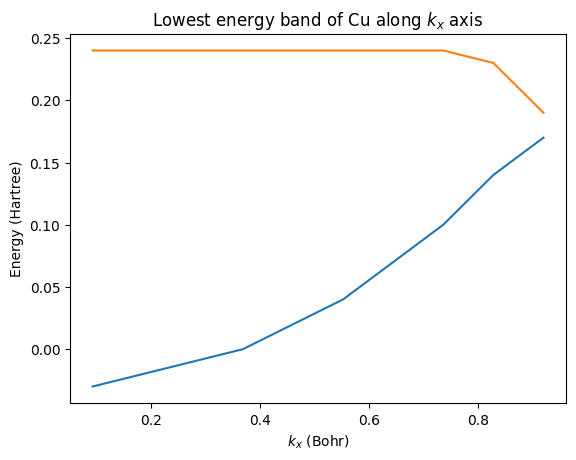

In [ ]:
#graphs, due to lack of electron-electron interactions this is not going to be very accurate
kx = list(map(lambda k: k[0],ks))
plt.plot(kx,E0s)
plt.plot(kx,E1s)
plt.title(R"Lowest energy band of Cu along $k_x$ axis")
plt.xlabel(r"$k_x$ (Bohr)")
plt.ylabel("Energy (Hartree)")
plt.show() #have added 0 at the end